In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from time import sleep
import warnings
from tqdm import trange
warnings.filterwarnings("ignore")

# Уравнение ФитцХью-Нагумо

## Постановка задачи

Есть следующая система уравнений:

$\begin{cases}
\cfrac{\partial u}{\partial t} = u(a - u)(u - 1) - v + I + D \cfrac{\partial^2 u}{\partial x^2} \\
\cfrac{\partial v}{\partial t} = bu - \gamma v
\end{cases}, x \in [0, X], t \in [0, T]$

Эта система качественно описывает распространение нервного импульса. Переменная $u$ есть потенциал мембраны нейрона, а $v$ отвечает за токи, которые возвращают систему в состояние покоя.

## Метод решения

Решим эту задачу шеститочечным методом, а именно, предложим для решения задачи следующую разностную схему:

$\begin{cases}
\cfrac{u^{n+1}_m - u^n_m}{\tau} = (1 - \xi) \left[u^n_m(a-u^n_m)(u^n_m-1) - v_m^n + I + D\cfrac{u^n_{m-1} - 2u_m^n + u_{m+1}^n}{h^2}\right] + + \xi\left[u^{n+1}_m(a-u^{n+1}_m)(u^{n+1}_m-1) - v_m^{n+1} + I + D\cfrac{u^{n+1}_{m-1} - 2u_m^{n+1} + u_{m+1}^{n+1}}{h^2}\right] \\
\cfrac{v^{n+1}_m-v^n_m}{\tau} = bu^n_m - \gamma v^n_m
\end{cases}, \\
\text{где } \tau \cdot N = T, h\cdot M = X.$

Эта система сводится к следующей:

$\begin{cases}
Au^{n+1} = f(u^{n+1}, u^n)\\
v^{n+1} = g(u^n, v^n)
\end{cases}, \text{где } u^n = (u^n_0, u^n_1, .., u^n_m)^T, v^n = (v^n_0, v^n_1, .., v^n_m)^T$ 

## Постановка граничных и начальных условий

Решим задачу для бесконечного нейрона, соответственно, нам нужно поставить только левые граничные условия:

$\begin{cases}
u(0, t) = \begin{cases}
u_0\sin\left(\cfrac{\pi t}{t_0}\right),\, t < t_0\\
0,\, t > t_0
\end{cases}\\
v(0, t) = 0
\end{cases}$

Начальные условия:

$\begin{cases}
u(x, 0) = 0 \\
v(x, 0) = 0
\end{cases}$

# Реализация

In [9]:
def f_init(t, t_0):
    if t < t_0:
        return np.sin(np.pi*t/t_0)
    else:
        return 0

In [10]:
def f_sixpoint_adv(u_n_1, u_n, n, N, M, f_init, t_0, ksi, D, tau, h, a, v_n, v_n_1, I):
    F = np.zeros(M+N+1-n)
    F[0] = u_n_1[0] - f_init((n+1)*tau, t_0)
    for m in range(1, M+N-1-n):
        F[m] = (u_n_1[m] - u_n[m]) / tau - ((1 - ksi) * D / h**2 * (u_n[m-1] - 2 * u_n[m] + u_n[m+1]) + \
                                           ksi * D / h**2 * (u_n_1[m-1] - 2 * u_n_1[m] + u_n_1[m+1]) + \
                                           (1 - ksi) * u_n[m] * (a - u_n[m]) * (u_n[m] - 1) + \
                                           ksi * u_n_1[m] * (a - u_n_1[m]) * (u_n_1[m] - 1) - \
                                           (1 - ksi) * v_n[m] - ksi * v_n_1[m] + I)
    return F

Коэффициенты следующие:

In [11]:
T = 1000
X = 300
N = 500
M = 300
tau = T / N
h = X / M
t_0 = 10
u_0 = 1

In [12]:
ksi = 1
D = 40
a = 0.1
I = 0
b = 0.002
gamma = 0.002

Решим численно систему: 

In [14]:
u_0_m = np.zeros(N+M+2)
u_n_0 = np.zeros(N+1)
for n in range(len(u_n_0)):
    u_n_0[n] = f_init(n*tau, t_0)
v_0_m = np.zeros(N+M+3)

In [15]:
u = [u_0_m]
v = [v_0_m]
for n in trange(N+1, leave=True):
    v_n_1 = tau * (b * u[n] - gamma * v[n][:-1]) + v[n][:-1]
    v.append(v_n_1)
    u_n_1 = optimize.fsolve(f_sixpoint_adv, np.zeros(M+N+1-n), args=(u[n], n, N, M, f_init, t_0, ksi, D, tau, h, a, v[n], v[n+1], I))
    u.append(u_n_1)

100%|██████████| 501/501 [15:19<00:00,  2.23it/s]


In [16]:
u_time = [[] for i in range(N+1)]
v_time = [[] for i in range(N+1)]
for i in range(N+1):
    u_time[i] = u[i][:M+1]
    v_time[i] = v[i][:M+1]
u_time = np.array(u_time)
v_time = np.array(v_time)

Посмотрим, как формируется импульс в пространстве и во времени. Сначала взглянем на пространственное формирование импульса. Видим, что импульс формируется очень быстро и уже при х=17 принимает свой характерный вид.(синий цвет - потенциал мембраны, оранжевый - токи, возвращаюшие систему в состояние покоя)

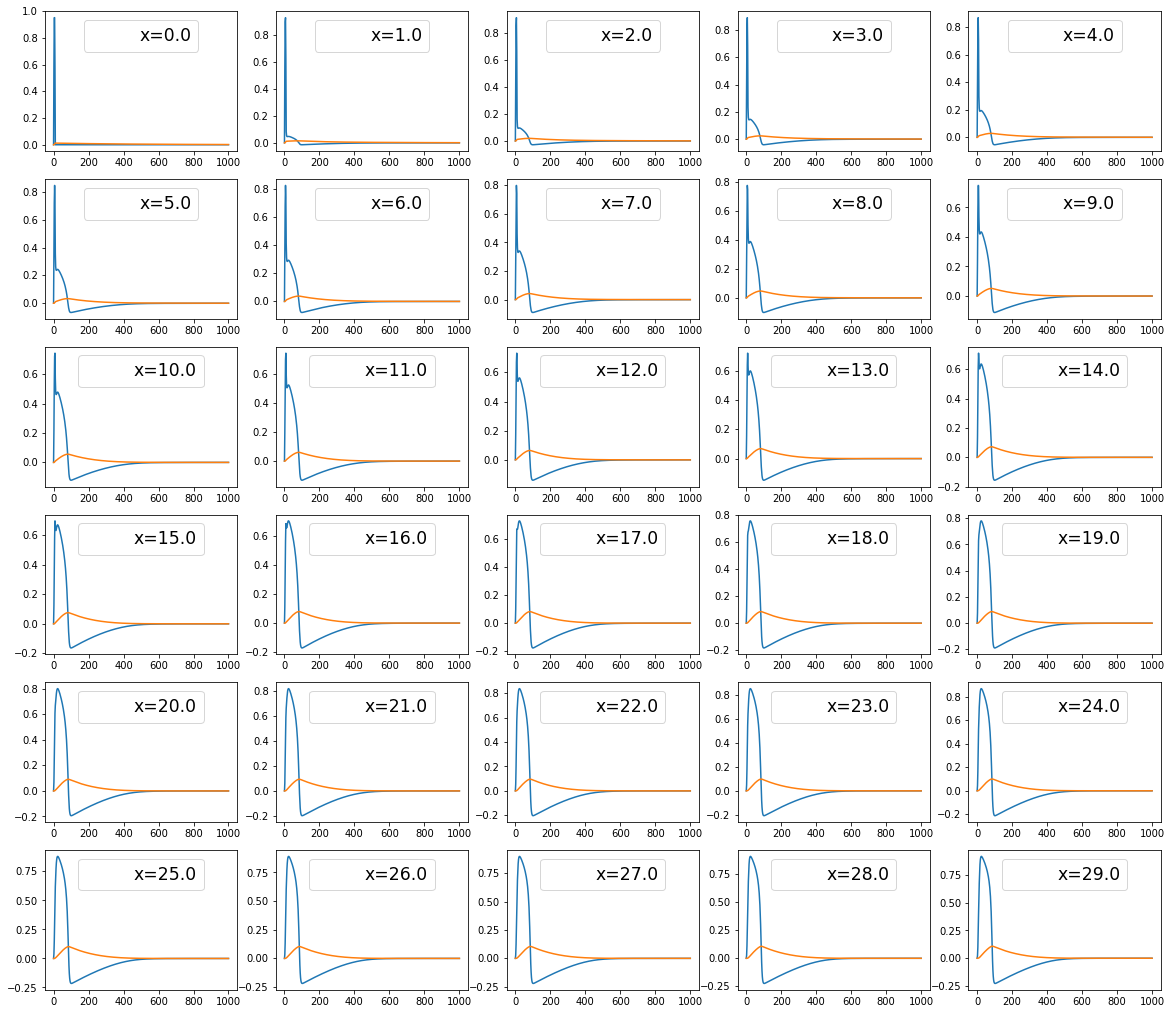

In [46]:
t = np.linspace(0, T, N+1)
x = np.linspace(0, X, M+1)
m_r = np.arange(0, 30, 1)
fig, ax = plt.subplots(len(m_r)//5, 5, figsize=(20, 18))
for i in range(len(m_r)):
    ax[i//5][i%5].plot(t, u_time[:, m_r[i]])
    ax[i//5][i%5].plot(t, v_time[:, m_r[i]])
    ax[i//5][i%5].plot(0, 0, color='white', label='x={}'.format(x[m_r[i]]))
    ax[i//5][i%5].legend(fontsize='xx-large', loc='upper center')

In [78]:
type(u_time)

numpy.ndarray

Видно, как бежит волна:

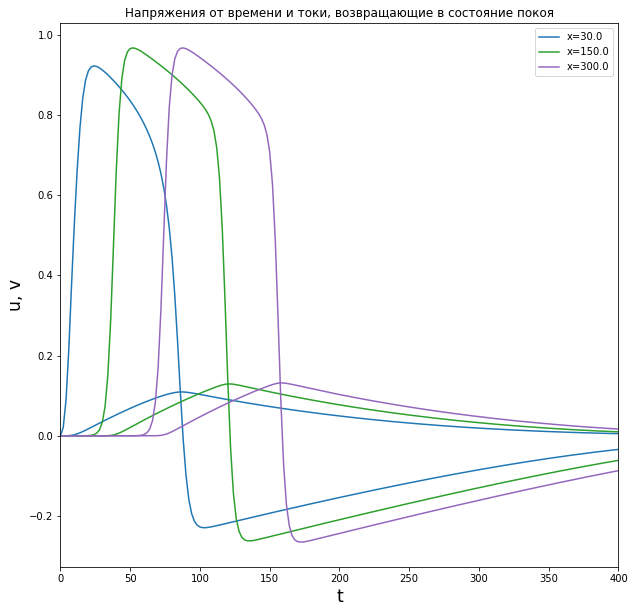

In [96]:
plt.figure(figsize=(10, 10))
mm = [30, 150, 300]
for m in mm:
    plt.plot(t, u_time[:, m], label='x={}'.format(x[m]))
    plt.plot(t, v_time[:, m], label='x={}'.format(x[m]))
ax1 = plt.axes()
axs = ax1.get_lines()
for i in [1, 3, 5]:
    axs[i].set_c(axs[i-1].get_c())
    axs[i].set_label('_' + axs[i-1].get_label())
plt.xlim(0, 400)
plt.xlabel('t', fontsize='xx-large')
plt.ylabel('u, v', fontsize='xx-large')
plt.legend()
plt.title('Напряжения от времени и токи, возвращающие в состояние покоя');

Теперь посмотрим на временное распределение импульса. Очень хорошо видно, как мембрана возбуждается и потом медленно возвращается в состояние покоя.(синий цвет - потенциал мембраны, оранжевый - токи, возвращаюшие систему в состояние покоя)

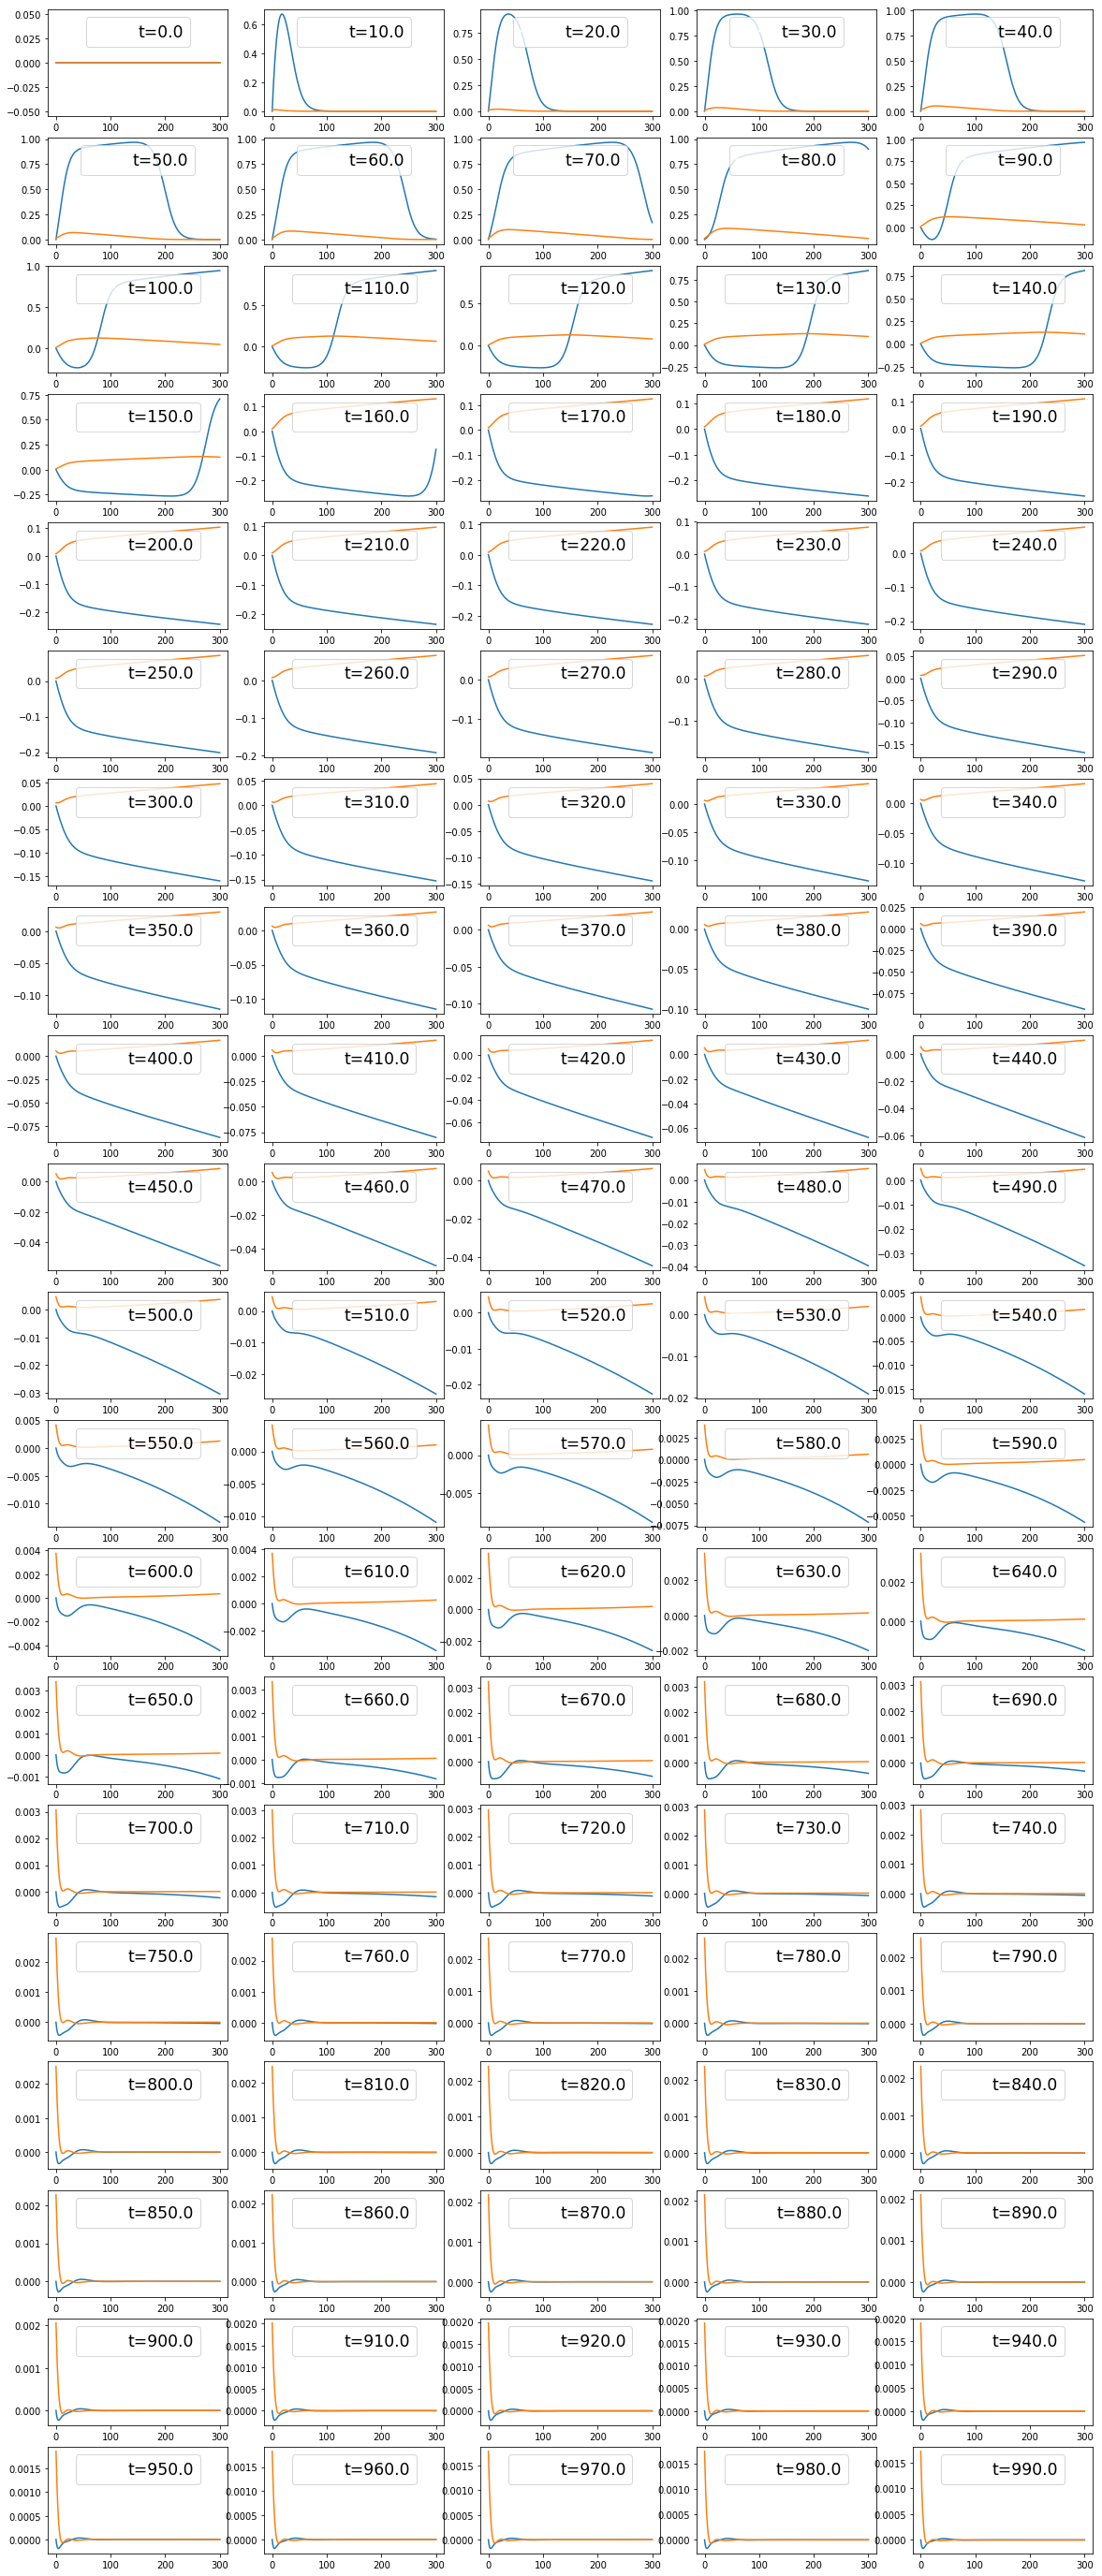

In [56]:
t = np.linspace(0, T, N+1)
x = np.linspace(0, X, M+1)
n_r = np.arange(0, 500, 5)
fig, ax = plt.subplots(len(n_r)//5, 5, figsize=(20, 50))
for i in range(len(n_r)):
    ax[i//5][i%5].plot(x, u_time[n_r[i], :])
    ax[i//5][i%5].plot(x, v_time[n_r[i],:])
    ax[i//5][i%5].plot(0, 0, color='white', label='t={}'.format(t[n_r[i]]))
    ax[i//5][i%5].legend(fontsize='xx-large', loc='upper center')

А теперь уменьшим амплитуду, то есть пусть $u_0=a$

In [69]:
def f_init_low(t, t_0):
    if t < t_0:
        return 0.1*np.sin(np.pi*t/t_0)
    else:
        return 0

In [70]:
u_0_m = np.zeros(N+M+2)
u_n_0 = np.zeros(N+1)
for n in range(len(u_n_0)):
    u_n_0[n] = f_init_low(n*tau, t_0)
v_0_m = np.zeros(N+M+3)

In [71]:
u_low = [u_0_m]
v_low = [v_0_m]
for n in trange(N+1, leave=True):
    v_n_1_low = tau * (b * u_low[n] - gamma * v_low[n][:-1]) + v_low[n][:-1]
    v_low.append(v_n_1_low)
    u_n_1_low = optimize.fsolve(f_sixpoint_adv, np.zeros(M+N+1-n), args=(u_low[n], n, N, M, f_init_low, t_0, ksi, D, tau, h, a, v_low[n], v_low[n+1], I))
    u_low.append(u_n_1_low)

100%|██████████| 501/501 [19:06<00:00,  1.44it/s]


In [72]:
u_time_low = [[] for i in range(N+1)]
v_time_low = [[] for i in range(N+1)]
for i in range(N+1):
    u_time_low[i] = u_low[i][:M+1]
    v_time_low[i] = v_low[i][:M+1]
u_time_low = np.array(u_time_low)
v_time_low = np.array(v_time_low)

Тогда видим, что импульс не будет распространяться, а будет затухать. Это означает, что есть какое-то предельное напряжение $u_0$, после которого становится возможным распространение волн. Это явление наблюдается в реальных нейронах.

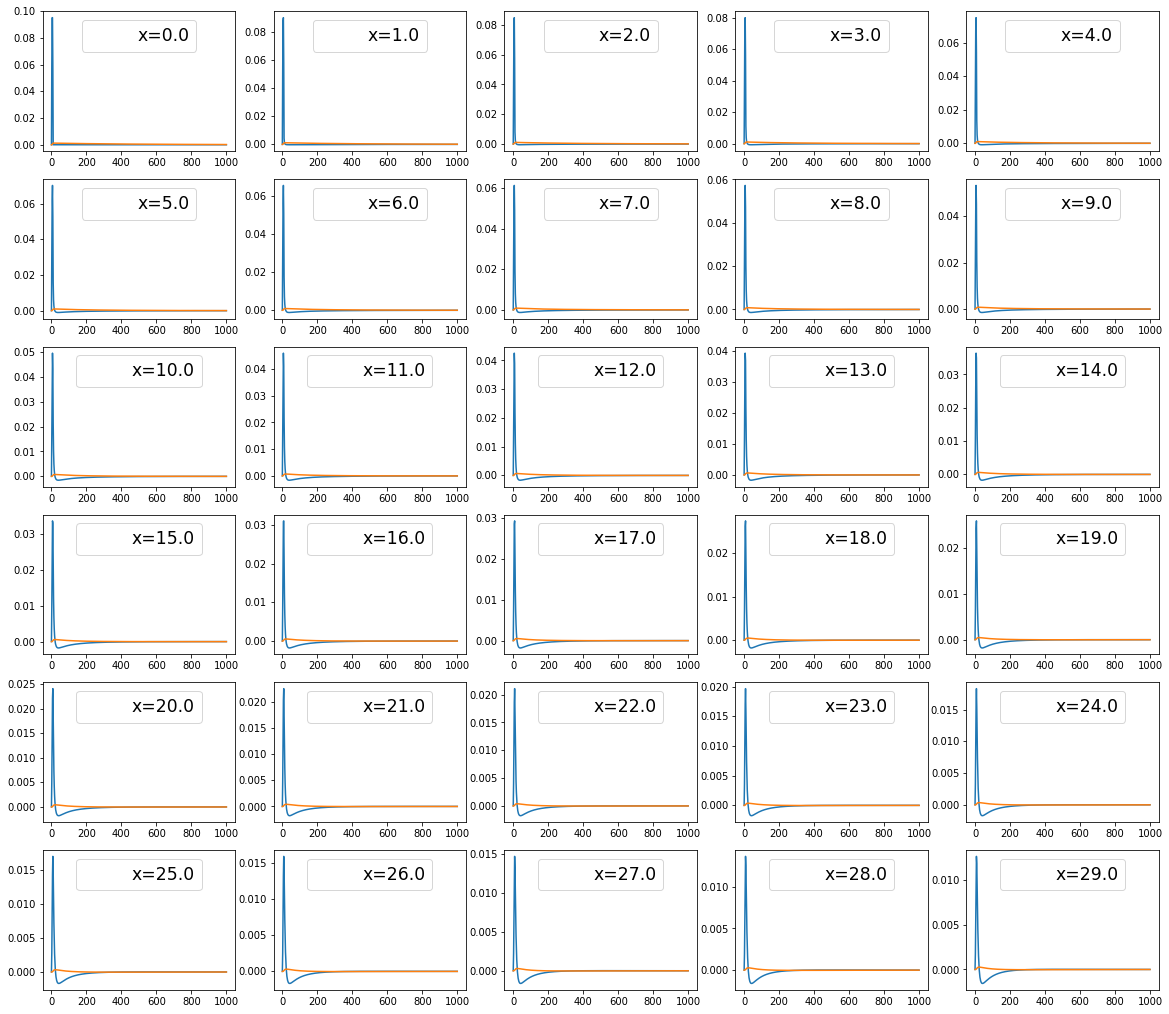

In [73]:
t = np.linspace(0, T, N+1)
x = np.linspace(0, X, M+1)
m_r = np.arange(0, 30, 1)
fig, ax = plt.subplots(len(m_r)//5, 5, figsize=(20, 18))
for i in range(len(m_r)):
    ax[i//5][i%5].plot(t, u_time_low[:, m_r[i]])
    ax[i//5][i%5].plot(t, v_time_low[:, m_r[i]])
    ax[i//5][i%5].plot(0, 0, color='white', label='x={}'.format(x[m_r[i]]))
    ax[i//5][i%5].legend(fontsize='xx-large', loc='upper center')

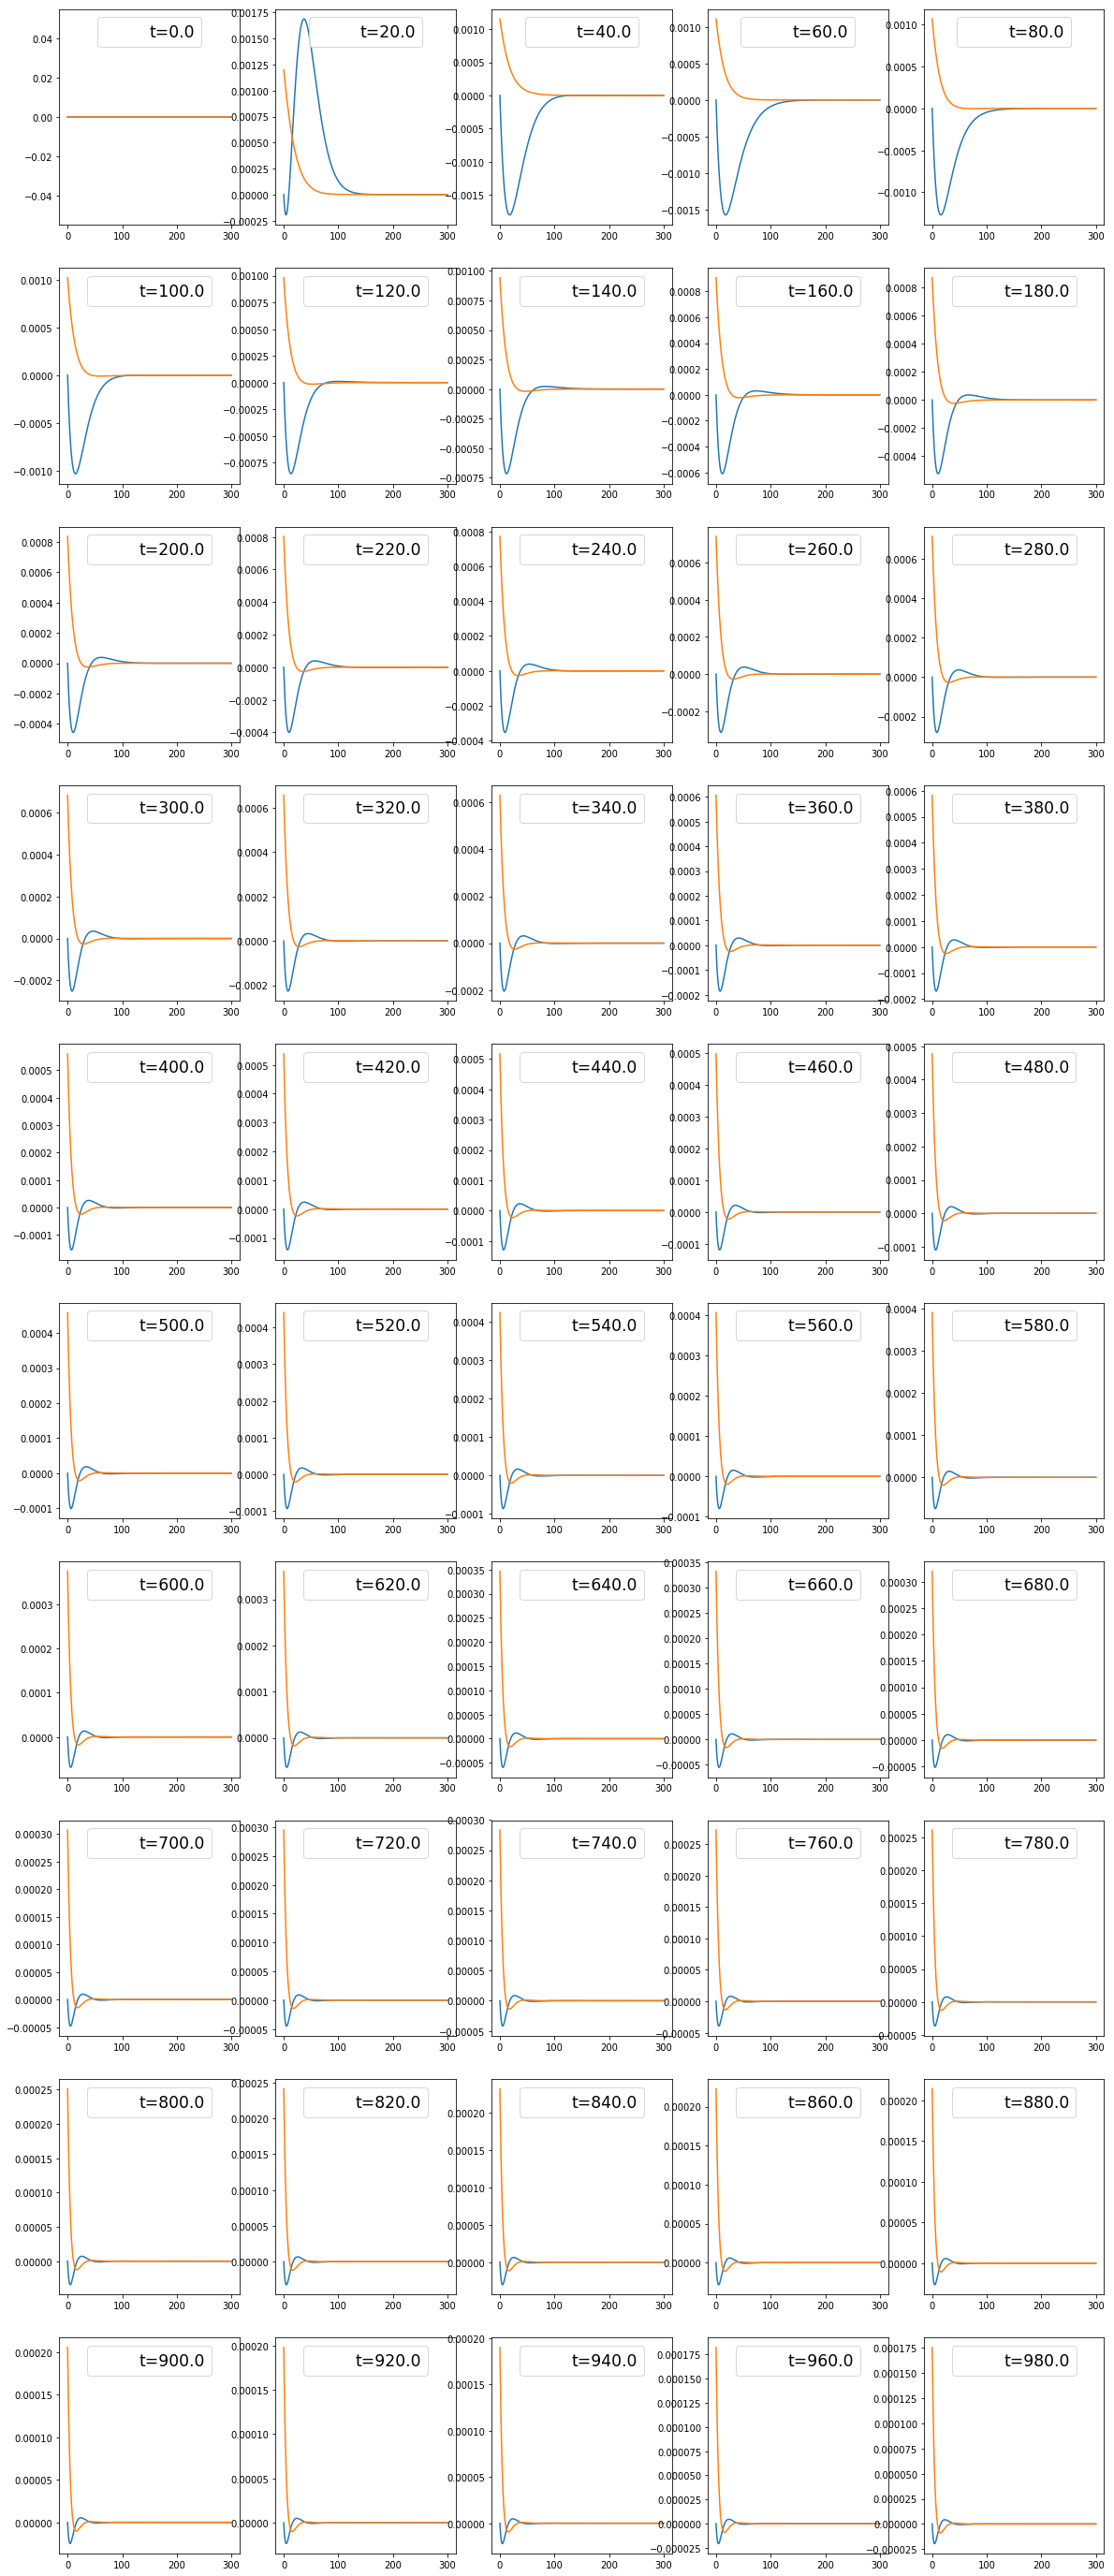

In [75]:
t = np.linspace(0, T, N+1)
x = np.linspace(0, X, M+1)
n_r = np.arange(0, 500, 10)
fig, ax = plt.subplots(len(n_r)//5, 5, figsize=(20, 50))
for i in range(len(n_r)):
    ax[i//5][i%5].plot(x, u_time_low[n_r[i], :])
    ax[i//5][i%5].plot(x, v_time_low[n_r[i],:])
    ax[i//5][i%5].plot(0, 0, color='white', label='t={}'.format(t[n_r[i]]))
    ax[i//5][i%5].legend(fontsize='xx-large', loc='upper center')